In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from scipy.optimize import minimize, basinhopping
from sklearn import preprocessing
import pyfolio as pf
%matplotlib inline

In [52]:
DATA_DIR = 'C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/Research/data/'

In [53]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [54]:
odf = pd.read_excel(fname, index_col=0)

In [55]:
odf.head()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE,H11025.CSI
2007-01-04,1461.2643,20025.58,1418.34,116.1885,158.58,0.0,1019.2584
2007-01-05,1474.4288,20211.28,1409.71,116.2254,156.94,0.0,1019.3131
2007-01-08,1522.0564,20029.66,1412.84,116.2289,153.72,0.0,1019.4650
2007-01-09,1564.7432,19898.08,1412.11,116.2638,154.45,0.0,1019.5195
2007-01-10,1603.9025,19568.34,1414.85,116.2990,154.34,0.0,1019.5750


In [56]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [57]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', '065.CS', 'AU9999.SGE']]

In [58]:
ret_df = df.pct_change().dropna()

In [112]:
months = pd.Series(ret_df.index.map(lambda x: (x.year, x.month)), index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='last').index

In [174]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        past_return = ret_df[ret_df.index <= date][-60:]
        if past_return.shape[0] == 60:
            sharpe = pd.Series(0., index=past_return.columns)
            for col in past_return.columns:
                sharpe[col] = pf.empyrical.sharpe_ratio(past_return[col])
            vol = past_return.std()
            wb = sharpe**2 / vol # Sharpe风险预算
            wb /= wb.sum()

In [175]:
weight.drop_duplicates().tail(n=10)

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE
2016-12-01,0.648834,0.000223955,0.0217328,0.0312446,0.297964
2017-01-03,0.0063461,0.0453501,0.0757655,0.787633,0.0849055
2017-02-03,0.00326756,0.00577817,0.267815,0.689251,0.0338886
2017-03-01,0.0103333,0.0245417,0.433943,0.479131,0.0520509
2017-04-05,0.0289868,0.356124,0.381499,0.0837509,0.149639
2017-05-02,0.000129987,0.12515,0.161541,0.581992,0.131187
2017-06-01,0.0326107,0.0637431,0.0014915,0.901831,0.00032356
2017-07-03,0.00552699,0.514313,0.16667,0.26495,0.048539
2017-08-01,0.00637096,0.0770627,0.0230881,0.893333,0.000145108
2017-09-01,0.0121107,0.0114201,0.00210674,0.972626,0.00173681


In [176]:
portfolio_ret = (weight * ret_df).sum(axis=1)

In [177]:
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [178]:
metric(portfolio_ret)

Annual return: 7.27%
Sharpe ratio: 1.68
Annual volatility: 4.23%
Max drawdown: -8.94%


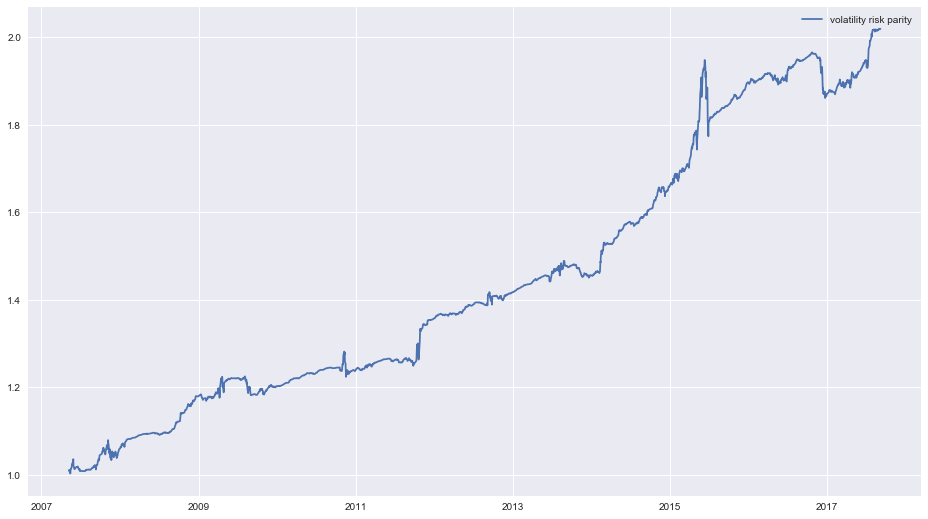

In [179]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='volatility risk parity')
plt.legend()

# 未来波动率

In [105]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        past_return = ret_df[ret_df.index >= date][121:]
        vol = past_return.std()
        wb = 1. / vol
        wb /= wb.sum()

In [106]:
portfolio_ret2 = (weight * ret_df).sum(axis=1)

In [107]:
portfolio_ret2 = portfolio_ret2[portfolio_ret2 != 0]

In [108]:
metric(portfolio_ret2)

Annual return: 4.68%
Sharpe ratio: 1.37
Annual volatility: 3.53%
Max drawdown: -6.97%


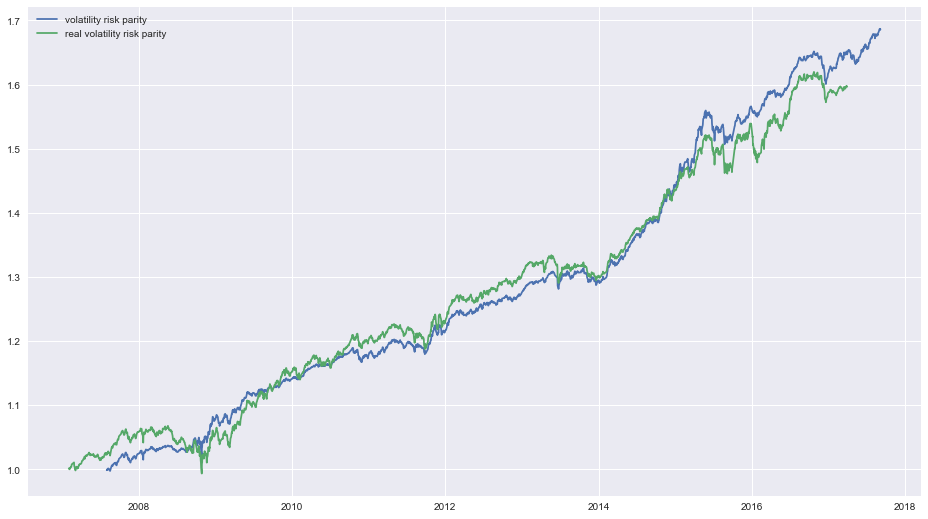

In [109]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='volatility risk parity')
plt.plot((1+portfolio_ret2).cumprod(), label='real volatility risk parity')
plt.legend()

In [110]:
df = pd.DataFrame({'past': (1+portfolio_ret).cumprod(), 'future': (1+portfolio_ret2).cumprod()})

In [111]:
df.to_excel('C:/Users/jgtzsx01/Desktop/rp.xlsx')